<a href="https://colab.research.google.com/github/Najme-naseri/Image-Procssing/blob/main/UnetImp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import PIL
import time
import os
import shutil
import cv2 as cv
import pandas as pd
import torchvision
from torch.utils.data import Dataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
#import matplotlib.image as img
from google.colab.patches import cv2_imshow

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
 print(f'Found {torch.cuda.device_count()} GPUs.')
 device = torch.device('cuda:0') # Manually pick your cuda device. By default is 'cuda:0'
 print(device)

Found 1 GPUs.
cuda:0


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d faizalkarim/flood-area-segmentation --unzip

 98% 105M/107M [00:06<00:00, 23.2MB/s]
100% 107M/107M [00:06<00:00, 17.8MB/s]


In [ ]:
%ls

drive/  Image/  Mask/  metadata.csv  sample_data/


In [ ]:
os.remove('/content/Image/0.jpg')

In [ ]:
os.remove('/content/Mask/0.png')

UNet Architecture

In [ ]:
class double_conv(nn.Module):
  def __init__(self , in_c, out_c):
    super().__init__()
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)
    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)
    self.relu = nn.ReLU(inplace = True)

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    return x


In [ ]:
class encoder(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.conv = double_conv(in_c, out_c)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.maxpool(x)
    return x, p


In [ ]:
def crop_img(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

In [ ]:
class decoder(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_c, out_c, 2, 2)
    self.conv = double_conv(out_c + out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    skip = crop_img(skip, x)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x


UNet

In [ ]:

class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.e1 = encoder(1, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    self.b = double_conv(512, 1024)

    self.d1 = decoder(1024, 512)
    self.d2 = decoder(512, 256)
    self.d3 = decoder(256, 128)
    self.d4 = decoder(128, 64)

    self.output = nn.Conv2d(64, 1, 1)

  def forward(self, inputs):
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    b = self.b(p4)

    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    outputs = self.output(d4)
    return outputs


initial parameter

In [ ]:
img_path=sorted(list(paths.list_images("/content/Image")))
mask_path=sorted(list(paths.list_images("/content/Mask")))
img_size = (128,128)
mask_size = (128,128)
test_split = 0.3
pin_memory = True if device == "cuda" else False
num_channels = 3
num_classes = 1
num_levels = 3
lr = 0.001
num_epochs = 5
batch_size = 16
threshold = 0.5
model_path = ""
plot_path = ""
test_path = ""

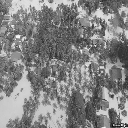

<class 'numpy.ndarray'>


In [ ]:
i=cv.imread(img_path[1], cv.IMREAD_GRAYSCALE)
i=cv.resize(i,img_size)
cv2_imshow(i)
print(type(i))

In [ ]:
class SegmentationDataset(Dataset):
	def __init__(self, img_path, mask_path, img_transforms, mask_transforms):
		# store the image and mask filepaths, augmentation, and transforms
		self.imagePaths = img_path
		self.maskPaths = mask_path
		self.img_transforms = img_transforms
		self.mask_transforms = mask_transforms
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]

		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv.imread(imagePath, cv.IMREAD_GRAYSCALE)
		mask = cv.imread(self.maskPaths[idx], cv.IMREAD_GRAYSCALE)
		
		#apply the transformations to both image and its mask
		mask = self.mask_transforms(mask)
		if image is None:
			print(f"imgpath: {imagePath}")
			print(type(image))
		image = self.img_transforms(image)
		# return a tuple of the image and its mask
		#if torch.is_tensor(image) and torch.is_tensor(mask):
		return (image, mask)

In [ ]:
split = train_test_split(img_path, mask_path,
												test_size = test_split, 
												random_state=42)
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

# define transformations
img_transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(img_size),
																	transforms.ToTensor()])

mask_transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize(mask_size),
																	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(img_path=trainImages, 
                              	mask_path=trainMasks,
																img_transforms=img_transforms,
																mask_transforms=mask_transforms)
testDS = SegmentationDataset(img_path=testImages, 
                            	mask_path=testMasks,
    													img_transforms=img_transforms,
															mask_transforms=mask_transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders

trainLoader = DataLoader(trainDS, shuffle=True,
													batch_size=batch_size, 
													pin_memory=pin_memory)
													#num_workers=os.cpu_count()

testLoader = DataLoader(testDS, shuffle=False,
													batch_size=batch_size,
													pin_memory=pin_memory)
													#num_workers=os.cpu_count()

[INFO] found 202 examples in the training set...
[INFO] found 87 examples in the test set...


In [ ]:
#clear memory
torch.cuda.empty_cache()
# initialize our UNet model
unet = Unet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	#i, j = 0, 0
	for i, (img, mask) in enumerate(trainLoader):
		# send the input to the device
		(img, mask) = (img.to(device), mask.to(device))
		# perform a forward pass and calculate the training loss
		pred = unet.forward(img)
		loss = lossFunc(pred, mask)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	#switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (img, mask) in testLoader:
			#torch.cuda.empty_cache()
			# send the input to the device
			(img, mask) = (img.to(device), mask.to(device))
			# make the predictions and calculate the validation loss
			pred = unet.forward(img)
			totalTestLoss += lossFunc(pred, mask)
	#print("try time: ", i)
	#except:
		#j += 1
		#print("except section run.", type(img))
		#print("shape in except section: ", img.shape)
		#print("except time: ", j)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.to('cpu').detach().numpy())
	H["test_loss"].append(avgTestLoss.to('cpu').detach().numpy())
	#H["train_loss"].append(avgTrainLoss)
	#H["test_loss"].append(avgTestLoss)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


 20%|██        | 1/5 [00:15<01:02, 15.54s/it]

[INFO] EPOCH: 1/5
Train loss: 0.565837, Test loss: 8.1408


 40%|████      | 2/5 [00:23<00:32, 10.79s/it]

[INFO] EPOCH: 2/5
Train loss: 0.496219, Test loss: 1.0254


 60%|██████    | 3/5 [00:30<00:18,  9.24s/it]

[INFO] EPOCH: 3/5
Train loss: 0.464324, Test loss: 1.4263


 80%|████████  | 4/5 [00:37<00:08,  8.52s/it]

[INFO] EPOCH: 4/5
Train loss: 0.429653, Test loss: 0.6203


100%|██████████| 5/5 [00:45<00:00,  9.04s/it]

[INFO] EPOCH: 5/5
Train loss: 0.413221, Test loss: 0.5566
[INFO] total time taken to train the model: 45.21s


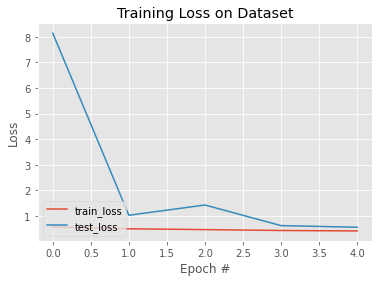

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig("")
# serialize the model to disk
#torch.save(model_path)

In [ ]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage, cmap='gray', interpolation='bicubic')
	ax[1].imshow(origMask, cmap='gray', interpolation='bicubic')
	ax[2].imshow(predMask, cmap='gray', interpolation='bicubic')
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	for ax in ax:
		ax.set_xticks([])
		ax.set_yticks([])
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
def make_predictions(model, imagePath, maskPath):
	# set model to evaluation mode
	model.eval()
	model = model.to(device)
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv.imread(imagePath, 0)
		#image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv.resize(image, img_size)
		orig = image.copy()
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		Mask = cv.imread(maskPath, 0)
		Mask = cv.resize(Mask, mask_size)
		#image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(device)
		print(image.shape)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model.forward(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > threshold) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, Mask, predMask)

torch.Size([1, 1, 128, 128])


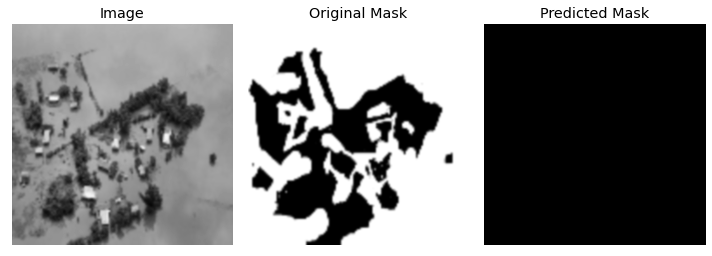

In [ ]:
make_predictions(Unet(), img_path[7], mask_path[7])